<a href="https://colab.research.google.com/github/vineet-codes/defi-exploration/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
def get_usernames(r=2):
  inputstring = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabscdefghijklmnopqrstuvwxyz0123456789'
  # print(len(inputstring))
  # username_list =list(set([inputstring[x:y] for x, y in itertools.combinations(range(len(inputstring) + 1), r = r)]))
  username_list = ['Harsh', 'Jennifer', 'Gary', 'Joe', 'Anubhav', 'Alan', 'Vineet', 'Dave', 'Anar', 'Wei', 'Brain', 'Barry', 'Danny', 'John', 'Michal',
                   'Tom', 'Blake', 'Asa', 'Georgie', 'Harry']
  return username_list

len(get_usernames())

20

Questions: 

1. How does unstake work [user has to claim it ?]: Not implemented at this point of time.

## Four main classes

1. Vault
2. Stakes
3. Rewards
4. Users

In [3]:
class Vault:

  def __init__(self, name):
    # pool is of the form {user: [(amount_1, tick_1), (amount_2, tick_2)]}
    self.pool = {}

    self.name = name
    # self.rewards_pool = rewards_pool
    # tick is used for having a contcept of time in our analysis
    self.tick = 0

  def update_tick(self, step):
    self.tick += step

  def balanceOf(self, user):
    user_txns = self.pool.get(user,[])
    if(len(user_txns) == 0):
      return 0 #f'It seems {user} has made no txns in to the Vault'
    return sum([amount for (amount, _) in user_txns])
    

  def shareOfUser(self, user):
    """
    return: users shares of the total pool
    """
    return self.balanceOf(user) / self.tvl()

  def deposit(self, amount, user):
    """
    return: tuple (user, updated balance)
    """
    if (user in self.pool.keys()):
      user_txns = self.pool.get(user, []) 
      user_txns.append((amount, self.tick))
      self.pool[user] = user_txns
    else:
      self.pool[user] = [(amount, self.tick)]
    return user, self.pool[user]

  def withdraw(self, withdraw_amount, user):
    """
    return: tuple (user, updated balance)
    """
    if(user not in self.pool.keys()):
      return f'{user} has not deposited in the vault'
    
    if(self.balanceOf(user) < withdraw_amount):
      return f'Not enough balance, {user} can one withdraw upto: {self.balanceOf(user)}'
    
    # db update
    # self.pool[user] = self.pool[user] - withdraw_amount
    self.pool[user].append((-1* withdraw_amount, self.tick))

    return user,self.balanceOf(user)

  def tvl(self):
    result = 0
    for user, txns in self.pool.items():
      user_balance = self.balanceOf(user)
      result += user_balance
    return result
      
    return sum([v for _,v in self.pool.items()])
  
  def get_pool(self):
    return self.pool



class Stakes:

  def __init__(self, name="YOP_LOCKBOX"):

    # pool is of the form {user: [(amount_1, duration_1, tick_1), (amount_2, duration_2, tick_2), (amount_1, duration_1, tick_2)]}
    self.pool = {}

    self.name = name
    # self.rewards_pool = rewards_pool
    # tick helps with time travel
    self.tick = 0

  def update_tick(self, step):
    self.tick += step

  def stake(self, user, amount, duration):
    """
    duratrion: in months
    """
    # assert self.tick == tick

    user_stakes = self.pool.get(user, [])
    # print(user_stakes)
    user_stakes.append((amount, duration, self.tick))
    self.pool[user] = user_stakes
    # self.rewards_pool.tick()
    return user, self.pool.get(user, [])

  def unstake(self):
    pass


  def get_pool(self):
    return self.pool

  def pool_size(self):
    return sum([amount*duration for user in self.pool.keys() for amount, duration, _ in self.pool[user]])

  def shareOfUser(self, user):
    totalPoolSize = self.pool_size()
    if(totalPoolSize == 0):
      return 0
    userPoolSize = sum([amount*duration for amount, duration, _ in self.pool.get(user, [(0,0,0)])])
    return userPoolSize / totalPoolSize



class Rewards:

  def __init__(self, vault, stakes, 
               weights=[0.2,0.8], 
               vault_stake_reward_split = [0.75, 0.25], 
               yearly_emissions = 3891931,
               yop_token_price = 1):
    
    self.tick = 0
    
    self.yearly_emissions = yearly_emissions

    self.vault = vault
    self.stakes = stakes

    self.weights = weights
    self.vault_stake_reward_split = vault_stake_reward_split
    self.yop_token_price = yop_token_price

    # list to store history state per tick
    self.reward_per_tick_history = []

  
  def update_tick(self, step):
    self.tick += step


  def calculate_rewards(self):

    result = {}
    
    total_power = 0
    for user in list(set(self.vault.pool.keys())):
      vault_boost_multiplier = self.weights[0]*self.vault.shareOfUser(user) + self.weights[1]*self.stakes.shareOfUser(user)
      total_power += vault_boost_multiplier * self.vault.balanceOf(user)

    # print(total_power)

    for user in list(set(self.vault.pool.keys())):
      # print("=========")
      vault_boost_multiplier = self.weights[0]*self.vault.shareOfUser(user) + self.weights[1]*self.stakes.shareOfUser(user)
      # print(f'{user} vault boost multiplier is: {vault_boost_multiplier}')
      # x = (vault_boost_multiplier * self.vault.balanceOf(user) / total_power) * ((self.vault_stake_reward_split[0]/4)*self.yearly_emissions) * (self.yop_token_price)
      x = ((vault_boost_multiplier * self.vault.balanceOf(user)) / total_power) * ((0.2)*self.yearly_emissions) * (self.yop_token_price)
      # print(f"{user} is getting {(x / self.vault.balanceOf(user))*100}% APY in the vault")
      result[user] = (x / self.vault.balanceOf(user))*100
    return result
 
    
  
  def tick_fn(self, step):


    # update clocks for everyone
    self.update_tick(step)
    self.vault.update_tick(step)
    self.stakes.update_tick(step)

    # TODO: calculate the rewards earned in this tick

    # TODO: unstake and calculate stake rewards to be persisted

    # calculate the current vault reward state to be persisted
    state = {}

    # print(f"===Tick: {self.tick}====")
    # print(self.calculate_rewards())
    # print("Vault pool",self.vault.pool)
    # print("Stake Pool", self.stakes.pool)

    state[f'apys_{self.tick}'] = self.calculate_rewards()
    state['vault_pool'] = self.vault.pool.copy()
    state['stake_pool'] = self.stakes.pool.copy()
    state['tvl'] = self.vault.tvl()
    state['stake_poolSize'] = self.stakes.pool_size()

    self.reward_per_tick_history.append(state)
    # print("========")

    
    
      

  


# v = Vault()
# print(v.tvl())
# print(v.balanceOf('dfg'))
# v.deposit(5000, 'e')
# print(v.tvl())

class User:

  def __init__(self, name):
    self.name = name

  def __repr__(self):
    return f'{self.name}'

  def vault_rewards(self):
    pass

  def stake_rewards(self):
    pass

In [4]:
usdc_vault = Vault('test')
yop_stakes = Stakes()
vineet = User("Vineet")
john = User("John")
anar = User("Anar")

reward_calculator = Rewards(usdc_vault, yop_stakes)

reward_calculator.tick_fn(1)

# users make deposit into vault
usdc_vault.deposit(50_000, vineet)
# yop_stakes.stake(john, 5000, 12)


reward_calculator.tick_fn(1)

usdc_vault.deposit(50_000, vineet)

reward_calculator.tick_fn(1)

usdc_vault.deposit(60_000, john)

# users stake some yop
yop_stakes.stake(vineet, 5000, 12)
reward_calculator.tick_fn(1)

yop_stakes.stake(vineet, 5000, 12)
reward_calculator.tick_fn(1)


reward_calculator.tick_fn(1)

In [5]:
usdc_vault.pool, usdc_vault.balanceOf(anar)

({John: [(60000, 3)], Vineet: [(50000, 1), (50000, 2)]}, 0)

In [6]:
usdc_vault.shareOfUser(vineet) + usdc_vault.shareOfUser(john) == 1

True

In [7]:
usdc_vault.withdraw(100000, vineet), usdc_vault.balanceOf(vineet), usdc_vault.tvl(), yop_stakes.get_pool()

((Vineet, 0), 0, 60000, {Vineet: [(5000, 12, 3), (5000, 12, 4)]})

##Toy Sheet setup: Replication our excel sheet

In [8]:
def toy_sheet_setup(steps = 100):

  # create vault and stake pool
  usdc_vault = Vault('test vault')
  yop_stakes = Stakes()
  rewards = Rewards(usdc_vault, yop_stakes)

  # create users
  vineet, john, anar = User("Vineet"), User("John"), User("Anar")

  # make some txns in vaults and stakes in some ticks
  # tick
  rewards.tick_fn(1)

  # users make deposit into vault
  usdc_vault.deposit(670_000, vineet)
  yop_stakes.stake(john, 100_000, 5)

  #tick 
  rewards.tick_fn(1)
  
  usdc_vault.deposit(2_000_000, john)

  # users stake some yop
  # yop_stakes.stake(vineet, 5000, 12)
  rewards.tick_fn(1)

  usdc_vault.deposit(5000, anar)

  yop_stakes.stake(anar, 50000, 5)
  rewards.tick_fn(1)

  # yop_stakes.stake(anar, 5000, 12)
  rewards.tick_fn(1)



  return rewards, usdc_vault, yop_stakes, [vineet, john, anar]

In [9]:
rewards, usdc_vault, yop_stakes, [vineet, john, anar] = toy_sheet_setup()

In [10]:
usdc_vault.pool, yop_stakes.pool, rewards.tick, rewards.calculate_rewards()

({Anar: [(5000, 3)], John: [(2000000, 2)], Vineet: [(670000, 1)]},
 {Anar: [(50000, 5, 3)], John: [(100000, 5, 1)]},
 5,
 {Anar: 14.840511248388022, John: 37.9496041256026, Vineet: 2.78389431724311})

In [11]:
rewards.reward_per_tick_history

[{'apys_1': {},
  'stake_pool': {},
  'stake_poolSize': 0,
  'tvl': 0,
  'vault_pool': {}},
 {'apys_2': {Vineet: 116.1770447761194},
  'stake_pool': {John: [(100000, 5, 1)]},
  'stake_poolSize': 500000,
  'tvl': 670000,
  'vault_pool': {Vineet: [(670000, 1)]}},
 {'apys_3': {John: 38.24237769141653, Vineet: 2.0206934584581293},
  'stake_pool': {John: [(100000, 5, 1)]},
  'stake_poolSize': 500000,
  'tvl': 2670000,
  'vault_pool': {John: [(2000000, 2)], Vineet: [(670000, 1)]}},
 {'apys_4': {Anar: 14.840511248388022,
   John: 37.9496041256026,
   Vineet: 2.78389431724311},
  'stake_pool': {Anar: [(50000, 5, 3)], John: [(100000, 5, 1)]},
  'stake_poolSize': 750000,
  'tvl': 2675000,
  'vault_pool': {Anar: [(5000, 3)],
   John: [(2000000, 2)],
   Vineet: [(670000, 1)]}},
 {'apys_5': {Anar: 14.840511248388022,
   John: 37.9496041256026,
   Vineet: 2.78389431724311},
  'stake_pool': {Anar: [(50000, 5, 3)], John: [(100000, 5, 1)]},
  'stake_poolSize': 750000,
  'tvl': 2675000,
  'vault_pool': 

In [12]:
common_users = list(set(rewards.vault.pool.keys()).intersection(set(rewards.stakes.pool.keys())))

In [13]:
common_users

[Anar, John]

## WIP: Setup Optimization simulation

In [14]:
import random

`setup_sim` sets up the simulation where for each `step` a tick is performed and then a randomly chosen user performs a randomly chosen action out of `['deposit', 'withdraw', 'stake', 'unstake']`. Then all the data is return ofr analysis.

In [57]:
def setup_sim(steps=900):

  actions = ['deposit', 'withdraw', 'stake', 'unstake']

  # instantiate vaults and staking pool
  usdc_vault = Vault('USDC_GENESIS')
  yop_stakes = Stakes()
  rewards = Rewards(usdc_vault, yop_stakes)

  action_history = []

  # generate random users from population of all users
  usernames = get_usernames()
  user_population = [User(username) for username in usernames]

  for tick in range(1, steps+1):
    # update the tick
    rewards.tick_fn(1)
    # for each tick
    #  pick a random user and a random action he takes
    user = random.choice(user_population[:20])
    action_name = random.choice(actions)

    # print(f"{user} {action_name}'s at tick {rewards.tick}")
    action_history.append({user: action_name, 'tick': rewards.tick})

    # execute the action
    if(action_name == 'deposit'):
      # deposit: user deposits a random amount in vault
      usdc_vault.deposit(100000, user)
    elif (action_name == 'withdraw'):
      balance = usdc_vault.balanceOf(user)
      usdc_vault.withdraw(balance/2, user)
    elif (action_name == 'stake'):
      yop_stakes.stake(user, 1000, 12)
    else:
      # unstake
      pass
  # print(rewards.calculate_rewards())
  return rewards, user_population, action_history

In [58]:
rewards, user_population, action_history = setup_sim()

In [59]:
len(rewards.vault.pool.keys()), rewards.vault.tvl()

(20, 3571081.54296875)

In [60]:
rewards.tick, rewards.vault.tick, rewards.stakes.tick

(900, 900, 900)

In [61]:
len(action_history)

900

What actions by which users were taken in this run of the simulation ? 

We record this in `action_history` array. Need to figure out a way of plotting this random walk. It is a random walk because each run of the simulation will generate a random actions by randomly picked users. The idea is to average over all the runs to idetify key variables.

In [62]:
action_history[:10]

[{Michal: 'stake', 'tick': 1},
 {Anar: 'unstake', 'tick': 2},
 {Anubhav: 'withdraw', 'tick': 3},
 {Michal: 'withdraw', 'tick': 4},
 {Wei: 'deposit', 'tick': 5},
 {Alan: 'stake', 'tick': 6},
 {Vineet: 'stake', 'tick': 7},
 {Harry: 'unstake', 'tick': 8},
 {Danny: 'withdraw', 'tick': 9},
 {Blake: 'unstake', 'tick': 10}]

What is historical apy's of users over the run of the simulation ? 

We have `rewards.reward_per_tick_history` array which has all this data. We need to plot this in an easy consumable way.

In [63]:
# rewards.reward_per_tick_history[-1][f'apys_{300}'], rewards.reward_per_tick_history[-2][f'apys_{299}']

In [64]:
rewards.vault.tvl()

3571081.54296875

In [65]:
def get_apy_per_tick():
  result = {}
  tvl_per_tick = [];
  user_balance_per_tick = []
  for i in range(0,rewards.tick):
    apys = rewards.reward_per_tick_history[i][f'apys_{i+1}']
    tvl_per_tick.append(rewards.reward_per_tick_history[i]['tvl'])

    user_vault_txns = rewards.reward_per_tick_history[i]['vault_pool']

    user_balances = {}
    for user, txns in user_vault_txns.items():
      user_balance = sum([amount for amount, _ in txns])
      user_balances[user] = user_balance

    user_balance_per_tick.append(user_balances)


    for user, apy in apys.items():
      users_apys = result.get(user, [])
      users_apys.append(apy)
      result[user] = users_apys

  for user, apy in result.items():
    # print(len(apy))
    result[user] =  [0 for i in range(300-len(apy))] + apy
  return result, tvl_per_tick, user_balance_per_tick

In [66]:
result, tvl_per_tick, user_balance_per_tick = get_apy_per_tick()

In [67]:
users = list(result.keys())

In [68]:
users[0]

Wei

In [69]:
len(result[users[10]])

841

APY's in Blue, TVL in red

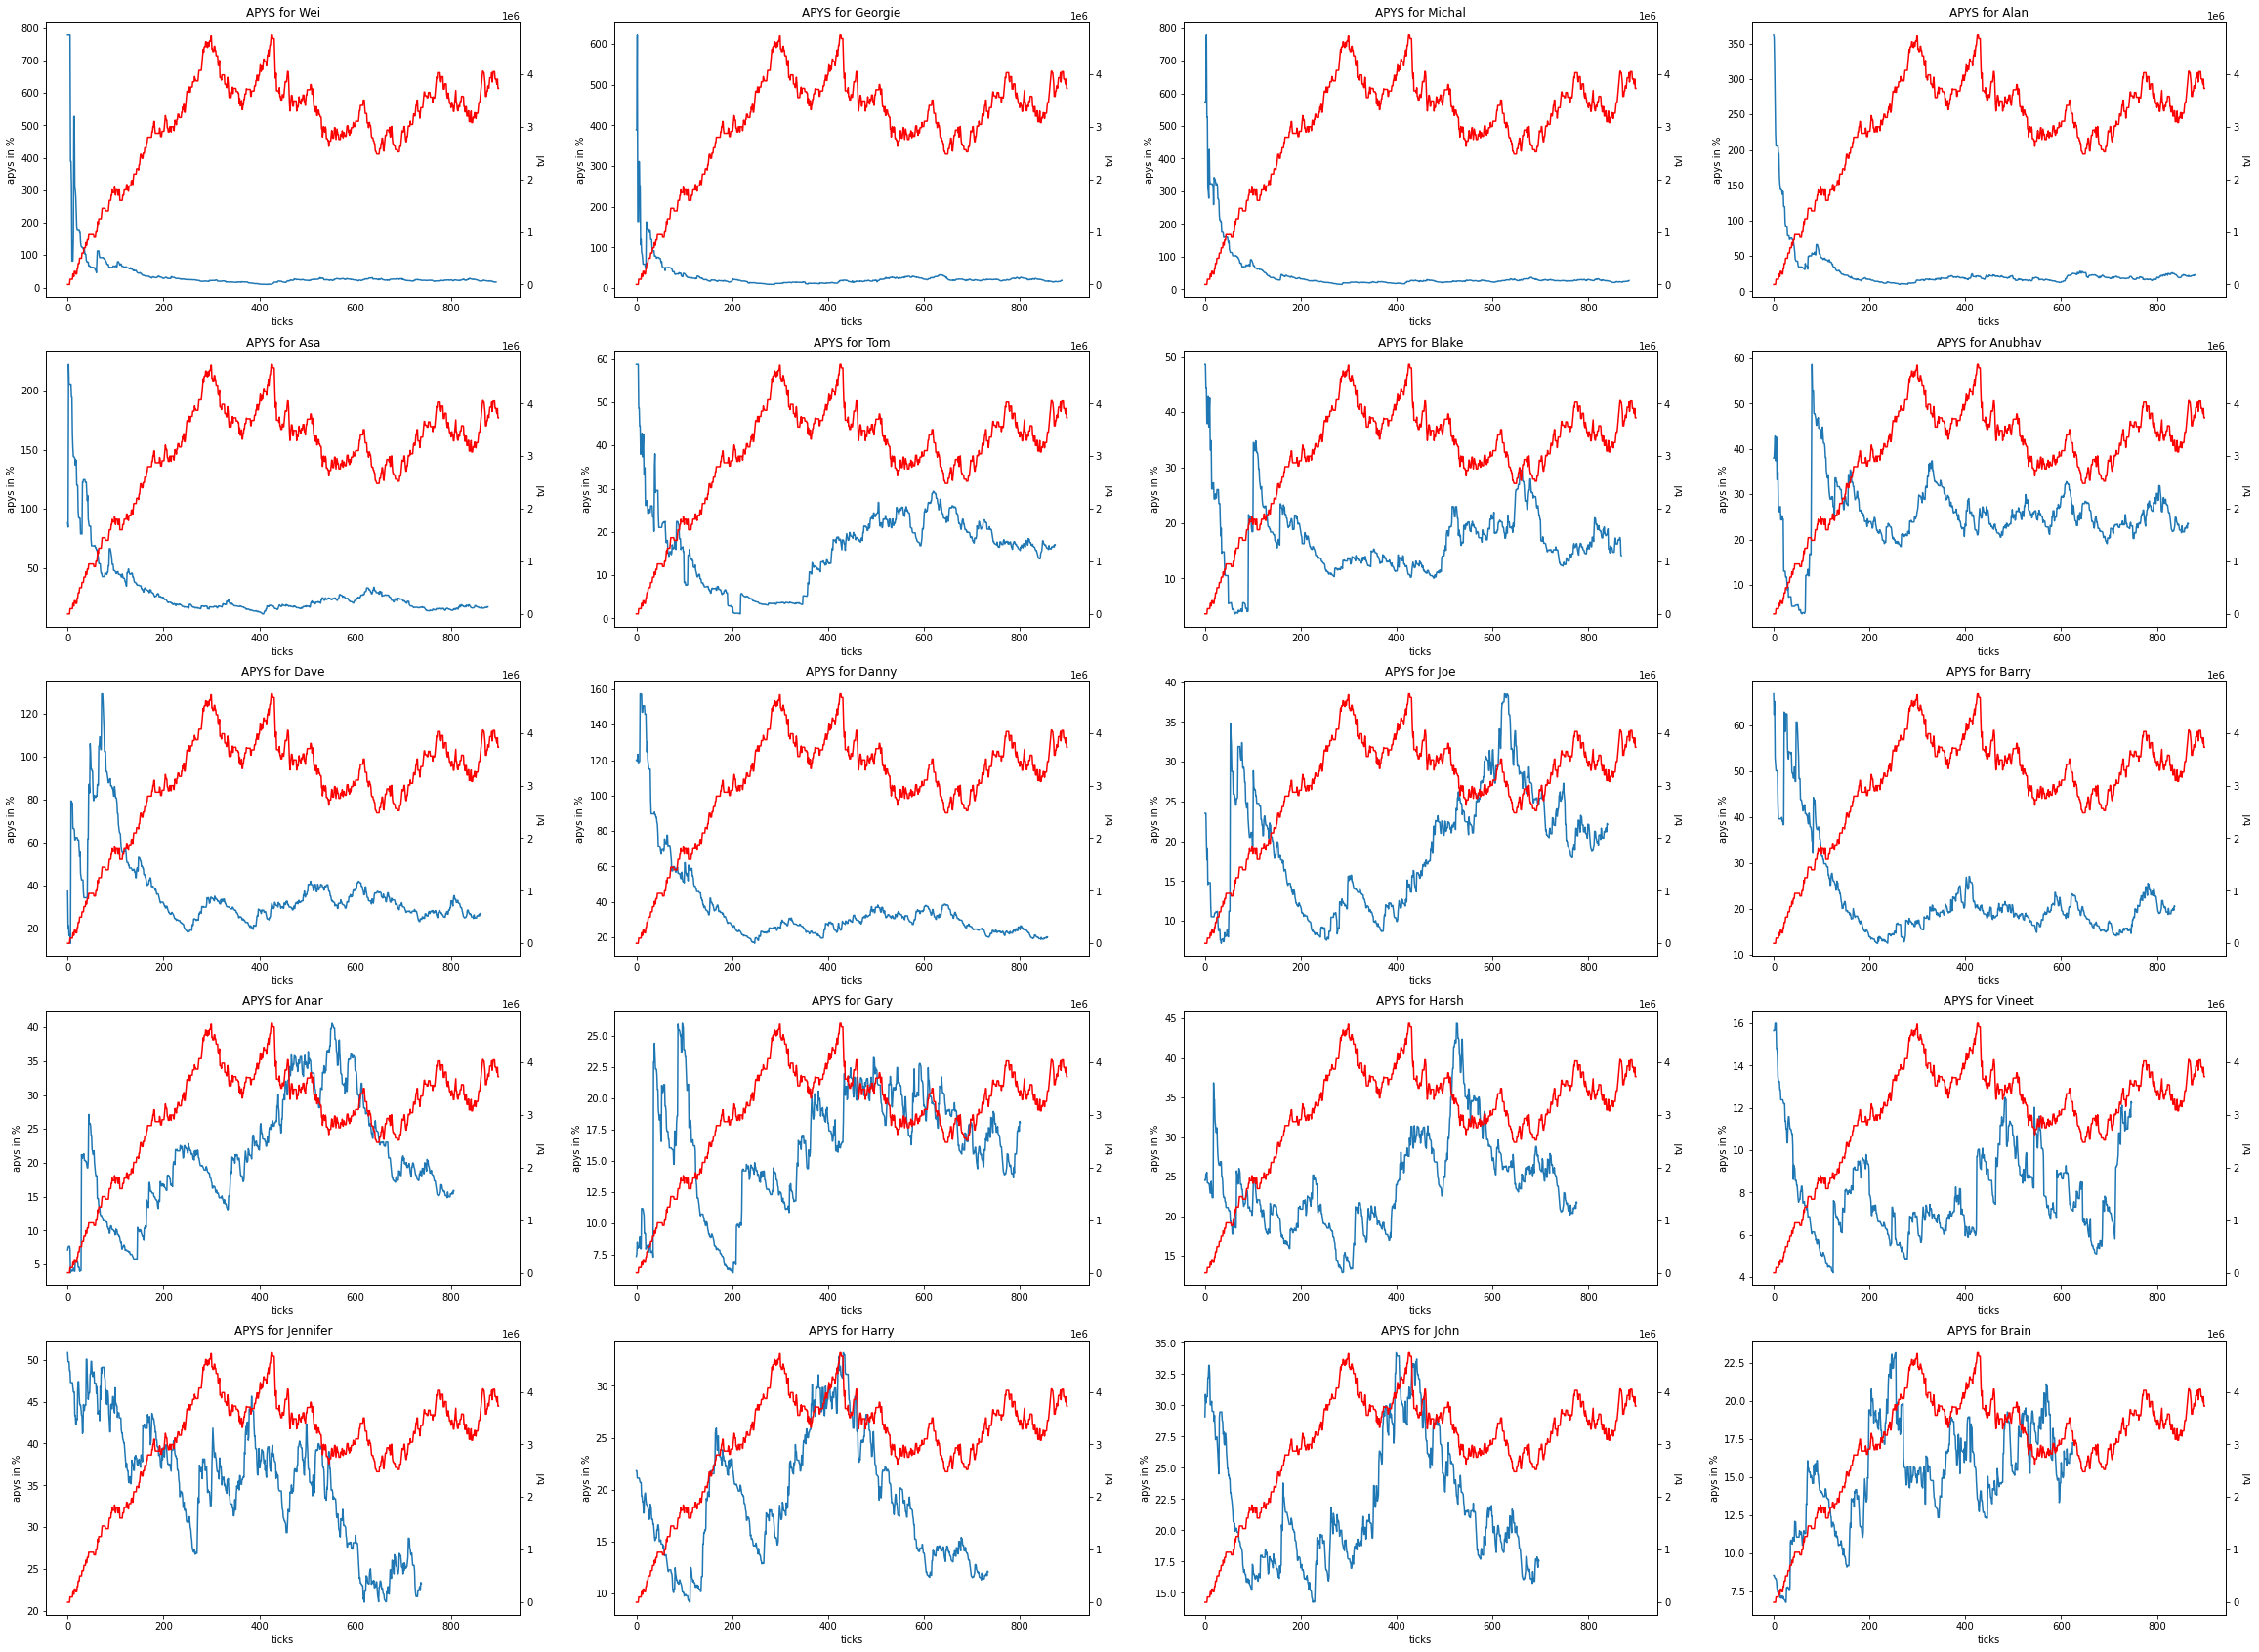

In [70]:
fig, axes = plt.subplots(5,4, figsize=(40,30))
for i,ax in enumerate(axes.flatten()):
  ax.plot(result[users[i]])
  ax.set_xlabel('ticks')
  ax.set_ylabel('apys in %')
  ax.set_title(f"APYS for {users[i]}")

  ax2 = ax.twinx()

  ax2.plot(tvl_per_tick, '-r')
  ax2.set_ylabel('tvl')

In [ ]:
len(rewards.reward_per_tick_history),rewards.reward_per_tick_history[-1]

(900,
 {'apys_900': {Alan: 7.708952525818251,
   Anar: 5.383319871051428,
   Anubhav: 6.170178930699488,
   Asa: 5.711385483424049,
   Barry: 7.3416654904893175,
   Blake: 4.807164843897387,
   Brain: 4.587143729168012,
   Danny: 8.237507272408692,
   Dave: 6.434067181807672,
   Gary: 5.798527466376103,
   Georgie: 5.070037857687199,
   Harry: 5.147422126553945,
   Harsh: 7.818412932929028,
   Jennifer: 3.480452565332211,
   Joe: 5.558295598070135,
   John: 5.780357090707273,
   Michal: 4.403781615476536,
   Tom: 5.012884958971016,
   Vineet: 9.745621003400116,
   Wei: 5.568335235763118},
  'stake_pool': {Alan: [(1000, 12, 8),
    (1000, 12, 81),
    (1000, 12, 199),
    (1000, 12, 286),
    (1000, 12, 361),
    (1000, 12, 397),
    (1000, 12, 407),
    (1000, 12, 435),
    (1000, 12, 452),
    (1000, 12, 478),
    (1000, 12, 487),
    (1000, 12, 535),
    (1000, 12, 562),
    (1000, 12, 622),
    (1000, 12, 701)],
   Anar: [(1000, 12, 82),
    (1000, 12, 154),
    (1000, 12, 251),
   

In [ ]:
len(user_balance_per_tick)

900

In [ ]:
balances_per_tick

{Alan: None,
 Anar: None,
 Anubhav: None,
 Asa: None,
 Barry: None,
 Blake: None,
 Brain: None,
 Danny: None,
 Dave: None,
 Gary: None,
 Georgie: None,
 Harry: None,
 Harsh: None,
 Jennifer: None,
 Joe: None,
 John: None,
 Michal: None,
 Tom: None,
 Vineet: None,
 Wei: None}